<a href="https://colab.research.google.com/github/gencturkmert/pointnet_implementation/blob/main/PointNet_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PointNet Implementation**

**Setup, Imports**

In [ ]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install numpy scipy


In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
from matplotlib import pyplot as plt


keras.utils.set_random_seed(seed=42)

**Dataset** - *ModelNet10*

In [ ]:
DATA_DIR = keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 [==============================] - 8s 0us/step


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

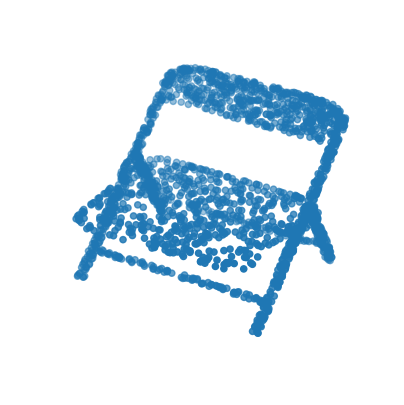

In [ ]:
NUM_POINTS = 2048
points = mesh.sample(NUM_POINTS)

def show_item(points):
  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(111, projection="3d")
  ax.scatter(points[:, 0], points[:, 1], points[:, 2])
  ax.set_axis_off()
  plt.show()

show_item(points)

Parse Dataset

In [ ]:
train_points = []
train_labels = []
test_points = []
test_labels = []
class_map = {}
folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

for i, folder in enumerate(folders):
    print("processing class: {}".format(os.path.basename(folder)))
    class_map[i] = folder.split("/")[-1]
    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files = glob.glob(os.path.join(folder, "test/*"))

    for f in train_files:
        train_points.append(trimesh.load(f).sample(NUM_POINTS))
        train_labels.append(i)

    for f in test_files:
        test_points.append(trimesh.load(f).sample(NUM_POINTS))
        test_labels.append(i)

processing class: night_stand
processing class: table
processing class: bed
processing class: monitor
processing class: dresser
processing class: chair
processing class: desk
processing class: toilet
processing class: bathtub
processing class: sofa


Dataset size:  3991
--------------------------------
Item Size:  2048
Item Shape:  (2048, 3)
Item Label:  7
Item Label Name:  toilet


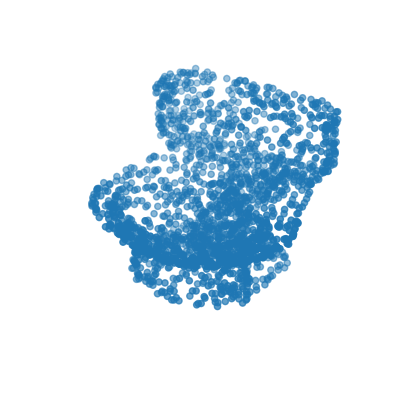

In [ ]:
def show_item_with_index(index,train_points) :
  print("Dataset size: ",len(train_points))
  print("--------------------------------")
  print("Item Size: ",len(train_points[index]))
  print("Item Shape: ",train_points[index].shape)
  print("Item Label: ",train_labels[index])
  print("Item Label Name: ", class_map[train_labels[index]])
  show_item(train_points[index])

show_item_with_index(np.random.randint(0,len(train_points)),train_points)


**Augment the Dataset**

In [ ]:
def augment(points,label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype="float64")
    points = tf.random.shuffle(points)
    return points,label

from scipy.spatial.transform import Rotation

def rotate_point(points,label):
    random_axis = np.random.rand(3)
    random_angle = np.random.uniform(0, 2*np.pi)
    rotation_matrix = Rotation.from_rotvec(random_angle * random_axis)
    points =  rotation_matrix.apply(points)

    return points,label

def rotate_cloud(items):
    random_axis = np.random.rand(3)
    random_angle = np.random.uniform(0, 2*np.pi)
    rotation_matrix = Rotation.from_rotvec(random_angle * random_axis)

    rotated_items = []
    for item in items:
        rotated_item = rotation_matrix.apply(item)
        rotated_items.append(rotated_item)

    return rotated_items


Rotate points

Dataset size:  3991
--------------------------------
Item Size:  2048
Item Shape:  (2048, 3)
Item Label:  5
Item Label Name:  chair


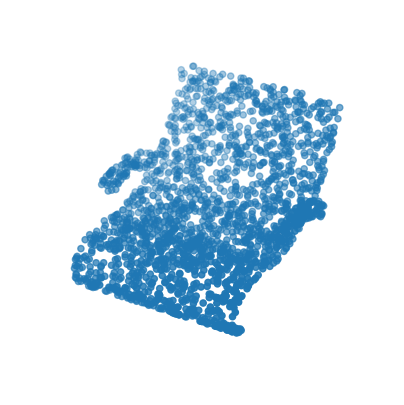

Dataset size:  3991
--------------------------------
Item Size:  2048
Item Shape:  (2048, 3)
Item Label:  5
Item Label Name:  chair


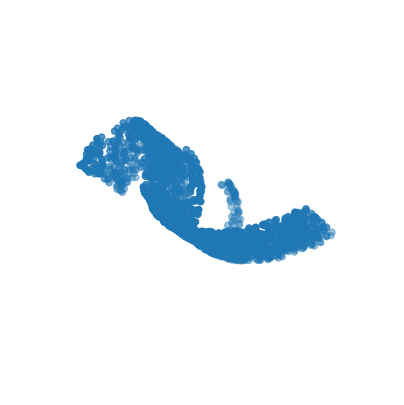

In [ ]:
rotated_points = rotate_cloud(train_points)

index = np.random.randint(0,len(train_points))
show_item_with_index(index,train_points)
show_item_with_index(index,rotated_points)

In [ ]:
aug_train_points = np.vstack((train_points,rotated_points))
print("Augmented points: ",aug_train_points.shape)
aug_train_labels = np.hstack((train_labels,train_labels))
print("Labels: ",aug_train_labels.shape)

Augmented points:  (19955, 2048, 3)
Labels:  (2, 15964)


In [ ]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
print(dataset.element_spec)
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

ValueError: Dimensions 15964 and 2 are not compatible

In [ ]:
NUM_CLASSES = 10
BATCH_SIZE = 32

dataset = dataset.shuffle(len(train_points)).map(augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)